In [1]:
import datetime
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.font_manager as fm
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import welch
from scipy.signal.windows import hamming
from scipy.signal import welch
from scipy.signal.windows import hamming
import scipy.io

In [2]:
# msToProcess: O valor é ajustado de forma a garantir que todos subquadros sejam processados e incluídos na saída do sistema.
# Os primeiros 1000 milissegundos (1 segundo) podem ser excluídos para lidar com qualquer resposta transitória que ocorra no
#  início do processamento.
# IF: Frequência Intermediária do sinal GPS signal, Hz
# Frequência na qual o sinal GPS é amostrado
# acqSearchBand: especifica a faixa de frequência em que o sistema irá procurar os sinais dos satélites. 
# Esse valor é dado em kHz (quilohertz), sendo um número inteiro. A faixa de frequência definida por acqSearchBand é centrada 
# ao redor da frequência intermediária (IF), ou seja, a faixa de pesquisa será construída em torno da frequência IF.
# acqThreshold: Limiar do detector

# fileNameStr='C:\Repository\SoftGNSS\GNSS_signal_records\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'
# msToProcess = 37000.0
# numberOfChannels = 8
# IF = 9548000.0
# samplingFreq = 38192000.0
# acqSearchBand = 14.0
# acqThreshold = 2.5
# pllDampingRatio = 0.7
# dllCorrelatorSpacing = 0.5
# elevationMask = 10.0

# fileNameStr=r'C:\Repository\GPSL1-DPEmodule\IF_Data_Set\Open Sky GPS L1.dat'
# msToProcess = 110000
# numberOfChannels = 12
# IF = 0
# samplingFreq = 10000000
# acqSearchBand = 7000
# acqThreshold = 1.8
# pllDampingRatio = 0.707
# dllCorrelatorSpacing = 0.3
# elevationMask = 0


fileNameStr=r'C:\Repository\GPSL1-DPEmodule\IF_Data_Set\Medium Urban in TST with one NLOS.dat'


msToProcess = 110000
numberOfChannels = 12
IF = 0
samplingFreq = 26000000
acqSearchBand = 7000
acqThreshold = 1.8
pllDampingRatio = 0.707
dllCorrelatorSpacing = 0.3
elevationMask = 0
resamplingThreshold = 8e6 # [Hz]
# Enable/dissable use of downsampling for acquisition
# 0 - Off
# 1 - On
resamplingflag         = 0 



# Check the number of arguments ==========================================
if fileNameStr is None:
    if not isinstance(fileNameStr, str):
         raise TypeError('File name must be a string')

In [3]:
skipNumberOfBytes = 0
fileName = fileNameStr
dataType = 'int8'
codeFreqBasis = 1023000.0
codeLength = 1023
skipAcquisition = False
acqSatelliteList = range(1, 33)
dllNoiseBandwidth = 2.0
pllNoiseBandwidth = 25.0
navSolPeriod = 500.0
useTropCorr = True
plotTracking = True
c_settings = 299792458.0
startOffset = 68.802
dllDampingRatio = 0.707
fileType = 2
MMT = 0
DPE_nonCohInt = 1
DPE_cohInt = 20
DPE_latlong_span = 30
DPE_height_span = 50
DPE_clkBias_span = 20
CNo_accTime = 0.001
CNo_VSMinterval = 40



# dataType: 'schar'
# fileType: 2
# resamplingThreshold: 8000000
# resamplingflag: 0
# dllDampingRatio: 0.707
# truePosition: [1×1 struct]
# plotTracking: 0
# CNo: [1×1 struct]
settings_gt_llh = np.array([22.299866, 114.180036, 16])

# chipspacing_dpe_precalc: 0.0393461538461538
# candPVT_spacing: 1
# DPE_plotCorrelogram: 0

# MMT_const: 0.8
# outfile_root: 'Medium Urban in TST with one NLOS'

In [4]:
from utils.generateCAcode import generateCAcode
from utils.makeCaTable import makeCaTable
from utils.calcLoopCoef import calcLoopCoef
from utils.navPartyChk import navPartyChk
from utils.findPreambles import findPreambles
from utils.bin2dec import bin2dec
from utils.checkPhase import checkPhase
from utils.twosComp2dec import twosComp2dec
from utils.ephemeris import ephemeris
from utils.calculatePseudoranges import calculatePseudoranges
from utils.check_t import check_t
from utils.generate_ca_code import generate_ca_code
from utils.make_ca_table import make_ca_table
from utils.e_r_corr import e_r_corr
from utils.togeod import togeod
from utils.topocent import topocent


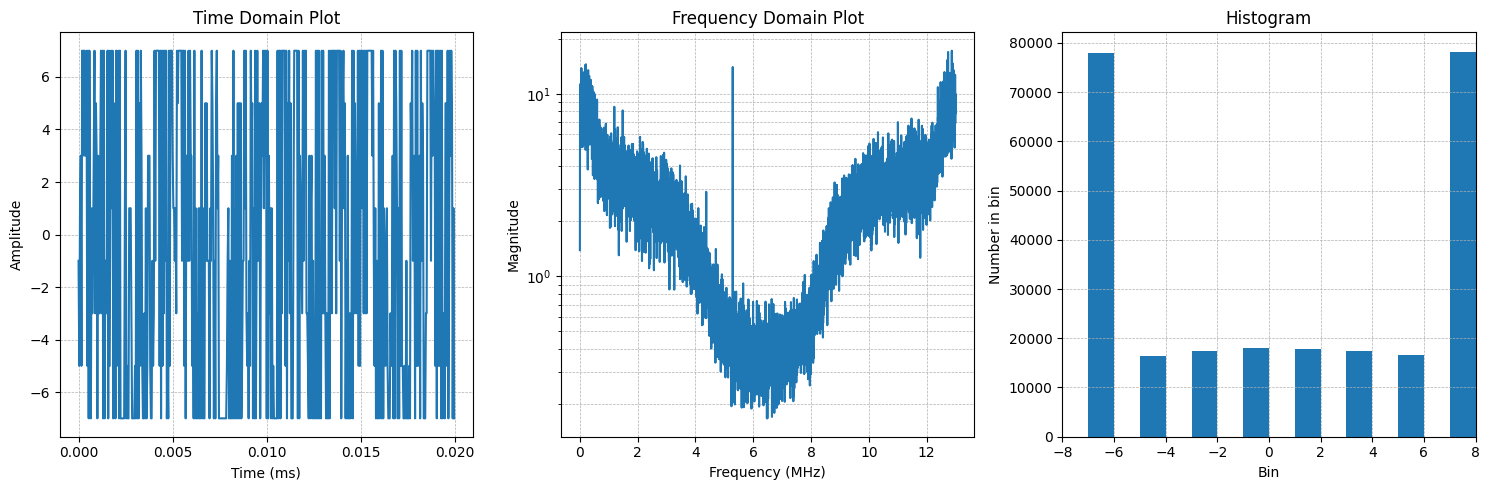

In [5]:
try:
        with open(fileNameStr, 'rb') as fid:
                fid.seek(skipNumberOfBytes, 0)
                samplesPerCode = np.int64(np.round(samplingFreq / (codeFreqBasis / codeLength)))
                try:
                        data = np.fromfile(fid, dataType, 10 * samplesPerCode)
                except IOError:
                    # The file is too short
                    print('Could not read enough data from the data file.')
except IOError as e:
        print('Unable to read file "%s": %s' % (fileNameStr, e))

timeScale = np.arange(0, 0.05, 1 / samplingFreq)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primeiro subplot: Domínio do Tempo
axs[0].plot(1000 * timeScale[:int(samplesPerCode / 50)], data[:int(samplesPerCode / 50)])
axs[0].set_title('Time Domain Plot')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
axs[0].set_xticks(np.arange(0, 0.025, 0.005)) # type: ignore

# Segundo subplot: Domínio da Frequência
f, Pxx = welch(data - np.mean(data), samplingFreq / 1e6, hamming(16384, False), 16384, 1024, 16384) # type: ignore
axs[1].semilogy(f, Pxx)
axs[1].set_title('Frequency Domain Plot')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Terceiro subplot: Histograma
dmax = np.max(np.abs(data)) + 1 # type: ignore
axs[2].hist(data, bins=np.arange(-128, 128))
axs[2].set_title('Histogram')
axs[2].set_xlabel('Bin')
axs[2].set_ylabel('Number in bin')
axs[2].set_xlim([-dmax, dmax])
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Ajustar layout
plt.tight_layout()
plt.show()

In [6]:
print('Starting processing...')
if not fileNameStr:
    fileNameStr = fileName
if not isinstance(fileNameStr, str):
    raise TypeError('File name must be a string')
with open(fileNameStr, 'rb') as fid:
    fid.seek(skipNumberOfBytes, 0)
    if not skipAcquisition:  # or 'acqResults' not in globals():
    # Find number of samples per spreading code
        samplesPerCode = samplesPerCode
        # frequency estimation
        data = np.fromfile(fid, dataType, 11 * samplesPerCode)

Starting processing...


In [7]:
# === Abrir o arquivo de dados ==========================================

try:
    fid = open(fileNameStr, 'rb')
except FileNotFoundError as e:
    print(f"Erro ao abrir o arquivo: {e}")
    exit()

# === Inicializar o multiplicador para ajustar o tipo de dado ===========
if fileType == 1:
    dataAdaptCoeff = 1
else:
    dataAdaptCoeff = 2

In [8]:
# === Se o arquivo foi aberto com sucesso ================================
if fid:

    # Mover o ponto de leitura no arquivo para começar a partir de N bytes
    fid.seek(dataAdaptCoeff * skipNumberOfBytes, os.SEEK_SET)

    # === Aquisição ========================================================

    if skipAcquisition is False:
        
        # Calcular número de amostras por código de espalhamento
        samplesPerCode = round(samplingFreq/(codeFreqBasis/codeLength))

        # Ler 11ms de dados para aquisição
        num_samples = dataAdaptCoeff * 11 * samplesPerCode

        # Ler os dados binários
        data = np.fromfile(fid, dtype=dataType, count=num_samples)

        # Ajustar sinal complexo, se necessário
        if dataAdaptCoeff == 2:
            data1 = data[::2]
            data2 = data[1::2]
            data = data1 + 1j * data2  # cria vetor complexo

    # fid.close()  # fecha o arquivo

In [9]:
# Acquisition initialization =============================================
# Find number of samples per spreading code
samplesPerCode = np.int64(np.round(samplingFreq / (codeFreqBasis / codeLength)))
longSignal = data
# Create two 1m sec vectors of data to correlate with and one with zero DC
signal1 = longSignal[0:samplesPerCode]
signal2 = longSignal[samplesPerCode:2 * samplesPerCode]
signal0DC = longSignal - longSignal.mean()
# Find sampling period
ts = 1.0 / samplingFreq
# Find phase points of the local carrier wave
phasePoints = np.arange(samplesPerCode) * 2 * np.pi * ts
# Number of the frequency bins for the given acquisition band (500Hz steps)
numberOfFrqBins = np.int64(np.round(acqSearchBand * 2/500) + 1)
# código antigo --> numberOfFrqBins = np.int64(np.round(acqSearchBand * 2) + 1)

In [10]:
caCodesTable = np.zeros((32, samplesPerCode))
# --- Find time constants --------------------------------------------------
ts = 1.0 / samplingFreq
tc = 1.0 / codeFreqBasis

In [11]:
# === For all satellite PRN-s ...
for PRN in range(32):
    # --- Generate CA code for given PRN -----------------------------------
    caCode = generate_ca_code(PRN)

    # --- Make index array to read C/A code values -------------------------
    # The length of the index array depends on the sampling frequency -
    # number of samples per millisecond (because one C/A code period is one millisecond).
    codeValueIndex = np.ceil(ts * np.arange(1, samplesPerCode + 1) / tc) - 1
    codeValueIndex = np.longlong(codeValueIndex)
    codeValueIndex[-1] = 1022

    # The "upsampled" code is made by selecting values form the CA code 
    # chip array (caCode) for the time instances of each sample.
    caCodesTable[PRN] = caCode[codeValueIndex]

# Generate all C/A codes and sample them according to the sampling freq.
caCodesTable = make_ca_table(samplingFreq, codeFreqBasis, codeLength)

# --- Initialize arrays to speed up the code -------------------------------
# Search results of all frequency bins and code shifts (for one satellite)
results = np.zeros((numberOfFrqBins, samplesPerCode))

# Carrier frequencies of the frequency bins
frqBins = np.zeros(numberOfFrqBins)

# --- Initialize acqResults ------------------------------------------------
# Carrier frequencies of detected signals
carrFreq = np.zeros(32)

# PRN code phases of detected signals
codePhase_ = np.zeros(32)

# Correlation peak ratios of the detected signals
peakMetric = np.zeros(32)
print(' Perform search for all listed PRN numbers ...')

 Perform search for all listed PRN numbers ...


In [12]:
for PRN in range(len(acqSatelliteList)):
    # Correlate signals, Coarse Acquisition  ======================================================
    # --- Perform DFT of PRN code ------------------------------------------
    caCodeFreqDom = np.fft.fft(caCodesTable[PRN, :]).conj()
    # --- Make the correlation for whole frequency band (for all freq. bins)
    for frqBinIndex in range(numberOfFrqBins):
        # --- Generate carrier wave frequency grid (0.5kHz step) -----------
        # frqBins[frqBinIndex] = IF - acqSearchBand / 2 * 1000 + 500.0 * frqBinIndex
        frqBins[frqBinIndex] = IF - acqSearchBand + 500 * frqBinIndex
        # --- Generate local sine and cosine -------------------------------
        sigCarr = np.exp(1j * frqBins[frqBinIndex] * phasePoints)
        # --- "Remove carrier" from the signal -----------------------------
        I1 = np.real(sigCarr * signal1)
        Q1 = np.imag(sigCarr * signal1)
        I2 = np.real(sigCarr * signal2)
        Q2 = np.imag(sigCarr * signal2)
        # --- Convert the baseband signal to frequency domain --------------
        IQfreqDom1 = np.fft.fft(I1 + 1j * Q1)
        IQfreqDom2 = np.fft.fft(I2 + 1j * Q2)
        # --- Multiplication in the frequency domain (correlation in time domain)
        convCodeIQ1 = IQfreqDom1 * caCodeFreqDom
        convCodeIQ2 = IQfreqDom2 * caCodeFreqDom
        # --- Perform inverse DFT and store correlation results ------------
        acqRes1 = abs(np.fft.ifft(convCodeIQ1))
        acqRes2 = abs(np.fft.ifft(convCodeIQ2))
        # --- Check which msec had the greater power and save that, will 
        # "blend" 1st and 2nd msec but will correct data bit issues
        if acqRes1.max() > acqRes2.max():
            results[frqBinIndex, :] = acqRes1
        else:
            results[frqBinIndex, :] = acqRes2
    # Look for correlation peaks in the results ==============================
    #  Find the highest peak and compare it to the second highest peak
    #  The second peak is chosen not closer than 1 chip to the highest peak
    # --- Find the correlation peak and the carrier frequency --------------
    frequencyBinIndex = results.max(1).argmax()
    # --- Find code phase of the same correlation peak ---------------------
    peakSize = results.max(0).max()
    codePhase = results.max(0).argmax()
    # --- Find 1 chip wide C/A code phase exclude range around the peak ----
    samplesPerCodeChip = np.int64(round(samplingFreq / codeFreqBasis))
    excludeRangeIndex1 = codePhase - samplesPerCodeChip
    excludeRangeIndex2 = codePhase + samplesPerCodeChip
    # --- Correct PRN code phase exclude range if the range includes array boundaries
    if excludeRangeIndex1 <= 0:
        codePhaseRange = np.r_[excludeRangeIndex2:samplesPerCode + excludeRangeIndex1 + 1]
    elif excludeRangeIndex2 >= samplesPerCode - 1:
        codePhaseRange = np.r_[excludeRangeIndex2 - samplesPerCode:excludeRangeIndex1]
    else:
        codePhaseRange = np.r_[0:excludeRangeIndex1 + 1, excludeRangeIndex2:samplesPerCode]
    # --- Find the second highest correlation peak in the same freq. bin ---
    secondPeakSize = results[frequencyBinIndex, codePhaseRange].max()
    # --- Store result -----------------------------------------------------
    peakMetric[PRN] = peakSize / secondPeakSize
    # If the result is above threshold, then there is a signal ...
    if (peakSize / secondPeakSize) > acqThreshold:
    # Fine resolution frequency search =======================================
    # --- Indicate PRN number of the detected signal -------------------
        print('%02d' % (PRN + 1), end=' ')  
        # --- Generate 10msec long C/A codes sequence for given PRN --------
        caCode = generateCAcode(PRN)
        codeValueIndex = np.floor(ts * np.arange(1, 10 * samplesPerCode + 1) / (1.0 / codeFreqBasis))
        longCaCode = caCode[np.longlong(codeValueIndex % 1023)]
        # --- Remove C/A code modulation from the original signal ----------
        # (Using detected C/A code phase)
        xCarrier = signal0DC[codePhase:codePhase + 10 * samplesPerCode] * longCaCode
        # --- Compute the magnitude of the FFT, find maximum and the associated carrier frequency
        # --- Find the next highest power of two and increase by 8x --------
        fftNumPts = 8 * 2 ** (np.ceil(np.log2(len(xCarrier))))
        # --- Compute the magnitude of the FFT, find maximum and the associated carrier frequency
        fftxc = np.abs(np.fft.fft(xCarrier, np.int64(fftNumPts)))
        uniqFftPts = np.int64(np.ceil((fftNumPts + 1) / 2.0))
        fftMaxIndex = np.argmax(fftxc)
        fftFreqBins = np.arange(uniqFftPts) * samplingFreq / fftNumPts
        if fftMaxIndex > uniqFftPts:
            if fftNumPts % 2 == 0: 
                fftFreqBinsRev = -fftFreqBins[uniqFftPts - 2 : 0 : -1]
            else:  
                fftFreqBinsRev = -fftFreqBins[uniqFftPts - 1 : 0 : -1]
            fftMaxIndexRev = np.argmax(fftxc[uniqFftPts:])
            carrFreq[PRN] = fftFreqBinsRev[fftMaxIndexRev]
            carrFreq[PRN] = (-1)**(fileType-1) * carrFreq[PRN]

        else:
            # print(PRN,'ok', fileType)
            # Sinal no lado positivo da FFT
            carrFreq[PRN] = (-1)**(fileType-1) * fftFreqBins[fftMaxIndex]
        # --- Handle IF == 0 edge case ---
        if carrFreq[PRN] == 0:
            carrFreq[PRN] = 1

        # --- Store code phase result ---
        codePhase_[PRN] = codePhase
    else:
        # --- No signal with this PRN --------------------------------------
        print('. ', end=' ')  # Saída na mesma linha para os que falharam
    

.  .  .  .  .  .  .  .  .  .  .  .  .  14 .  16 .  .  .  .  .  .  .  .  .  .  .  .  .  .  31 32 

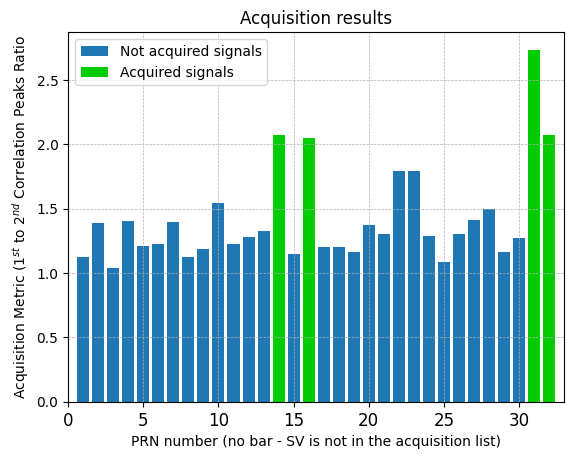


*=========*=====*===============*===========*=============*========*
| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |
*=========*=====*===============*===========*=============*========*
|       1 |  31 |  9.91821e+02  |     992   |     19852   |     T  |
|       2 |  32 |  -1.59931e+03 |   -1599   |      8564   |     T  |
|       3 |  14 |  -3.09944e+02 |    -310   |     21543   |     T  |
|       4 |  16 |  1.41335e+03  |    1413   |     13624   |     T  |
|       5 | --- |  ------------ |   -----   |    ------   |   Off  |
|       6 | --- |  ------------ |   -----   |    ------   |   Off  |
|       7 | --- |  ------------ |   -----   |    ------   |   Off  |
|       8 | --- |  ------------ |   -----   |    ------   |   Off  |
|       9 | --- |  ------------ |   -----   |    ------   |   Off  |
|      10 | --- |  ------------ |   -----   |    ------   |   Off  |
|      11 | --- |  ------------ |   -----   |    ------   |   Off  |
|      12 | --- |  ------------ |

In [13]:
# === Acquisition is over ==================================================
acqResults = np.core.records.fromarrays([carrFreq, codePhase_, peakMetric], names='carrFreq,codePhase,peakMetric')
acqResults._results = acqResults
assert isinstance(acqResults._results, np.recarray)
# Plot all results =======================================================
f, hAxes = plt.subplots()

# Plot barra para peakMetric
plt.bar(range(1, 33), acqResults.peakMetric)
plt.title('Acquisition results')
plt.xlabel('PRN number (no bar - SV is not in the acquisition list)')
plt.ylabel('Acquisition Metric ($1^{st}$ to $2^{nd}$ Correlation Peaks Ratio')

oldAxis = plt.axis()
plt.axis([0, 33, 0, oldAxis[-1]])
plt.xticks(range(1, 33), size=12)

# Mark acquired signals ==================================================
# acquiredSignals = acqResults.peakMetric * (acqResults.carrFreq > 0)
acquiredSignals = acqResults.peakMetric * (abs(acqResults.carrFreq) > 0)
# Alterar ticks do eixo X corretamente
hAxes.set_xticks(np.arange(0, 33, 5))  # Modifiquei para hAxes.set_xticks() que é o correto

# Plot barra para sinais adquiridos
plt.bar(range(1, 33), acquiredSignals, color=(0, 0.8, 0))

# Adicionar legenda
plt.legend(['Not acquired signals', 'Acquired signals'])

# Adicionar grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

if np.any(acqResults.carrFreq):
    assert isinstance(acqResults._results, np.recarray)
    PRN = np.zeros(numberOfChannels, dtype='int64')
    acquiredFreq = np.zeros(numberOfChannels)
    codePhase = np.zeros(numberOfChannels)
    status = ['-' for _ in range(numberOfChannels)]
    # --- Copy initial data to all channels ------------------------------------
    # Copy acquisition results ===============================================
    # --- Sort peaks to find strongest signals, keep the peak index information
    PRNindexes = sorted(enumerate(acqResults.peakMetric), key=lambda x: x[-1], reverse=True)
    # --- Load information about each satellite --------------------------------
    # Maximum number of initialized channels is number of detected signals, but
    # not more as the number of channels specified in the settings.
    for ii in range(min(numberOfChannels, sum(abs(acqResults.carrFreq) > 0))):
        PRN[ii] = PRNindexes[ii][0] + 1
        acquiredFreq[ii] = acqResults.carrFreq[PRNindexes[ii][0]]
        codePhase[ii] = acqResults.codePhase[PRNindexes[ii][0]]
        status[ii] = 'T'
    channel = np.core.records.fromarrays([PRN, acquiredFreq, codePhase, status],
                                     names='PRN,acquiredFreq,codePhase,status')
    acqResults._channels = channel
    # Prints the status of all channels in a table.
    # Inputs ================================================
    # channel - data for each channel. It is used to initialize and
    # at the processing of the signal (tracking part).
    # settings    - receiver settings
    channel = acqResults._channels
    # settings = self._settings
    assert isinstance(channel, np.recarray)
    print ('\n*=========*=====*===============*===========*=============*========*')
    print ('| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |')
    print ('*=========*=====*===============*===========*=============*========*')
    for channelNr in range(numberOfChannels):
        if channel[channelNr].status != '-' and channel[channelNr].acquiredFreq > 0:
            print('|      %2d | %3d |  %2.5e  |   %5.0f   |    %6d   |     %1s  |' 
                  % (channelNr+1,channel[channelNr].PRN,channel[channelNr].acquiredFreq,channel[channelNr].acquiredFreq - IF,
                     channel[channelNr].codePhase,channel[channelNr].status))
        elif channel[channelNr].status != '-' and channel[channelNr].acquiredFreq < 0:
            print('|      %2d | %3d |  %2.5e |   %5.0f   |    %6d   |     %1s  |' 
                  % (channelNr+1,channel[channelNr].PRN,channel[channelNr].acquiredFreq,channel[channelNr].acquiredFreq - IF,
                     channel[channelNr].codePhase,channel[channelNr].status))
        else:
            channelNr = channelNr+1
            print('|      %2d | --- |  ------------ |   -----   |    ------   |   Off  |' % channelNr)
    print('*=========*=====*===============*===========*=============*========*\n')
else:
    # No satellites to track, exit
    print('No GNSS signals detected, signal processing finished.')
    trackResults = None


In [14]:
data_settings = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\settings_dpe_sim.mat')
settings = data_settings['settings']

In [15]:
data_track = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\trackResults_dpe_sim.mat')
trackResults = data_track['trackResults']

In [16]:
data_nav = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\navSolutions_dpe_sim.mat')
navSolutions = data_nav['navSolutions']

In [17]:
fid = 168

In [18]:
settings_msToProcess = settings[0][0][0][0][0]

In [19]:
trackResults_status = []
trackResults_absoluteSample = []
trackResults_codeFreq = []
trackResults_carrFreq = []
trackResults_I_P = []
trackResults_I_E = []
trackResults_I_L = []
trackResults_Q_E = []
trackResults_Q_P = []
trackResults_Q_L = []
trackResults_dllDiscr = []
trackResults_dllDiscrFilt = []
trackResults_pllDiscr = []
trackResults_pllDiscrFilt = []
trackResults_remCodePhase = []
trackResults_remCarrPhase = []
trackResults_CNo = []
trackResults_PRN = []
for i in range(numberOfChannels):
    trackResults_status.append(trackResults[0][i][0][0])
    trackResults_absoluteSample.append(trackResults[0][i][1][0])
    try:
           trackResults_codeFreq.append(trackResults[0][i][2][0])
    except:
         trackResults_codeFreq.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_carrFreq.append(trackResults[0][i][3][0])
    except:
         trackResults_carrFreq.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_I_P.append(trackResults[0][i][4][0])
    except:
         trackResults_I_P.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_I_E.append(trackResults[0][i][5][0])
    except:
         trackResults_I_E.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_I_L.append(trackResults[0][i][6][0])
    except:
         trackResults_I_L.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_Q_E.append(trackResults[0][i][7][0])
    except:
         trackResults_Q_E.append([]) 
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_Q_P.append(trackResults[0][i][8][0])
    except:
         trackResults_Q_P.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_Q_L.append(trackResults[0][i][9][0])
    except:
         trackResults_Q_L.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_dllDiscr.append(trackResults[0][i][10][0])
    except:
         trackResults_dllDiscr.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_dllDiscrFilt.append(trackResults[0][i][11][0])
    except:
         trackResults_dllDiscrFilt.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_pllDiscr.append(trackResults[0][i][12][0])
    except:
         trackResults_pllDiscr.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_pllDiscrFilt.append(trackResults[0][i][13][0])
    except:
         trackResults_pllDiscrFilt.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_remCodePhase.append(trackResults[0][i][14][0])
    except:
         trackResults_remCodePhase.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_remCarrPhase.append(trackResults[0][i][15][0])
    except:
         trackResults_remCarrPhase.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_CNo.append(trackResults[0][i][16][0][0])
    except:
         trackResults_CNo.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_PRN.append(trackResults[0][i][17][0][0])
    except:
         trackResults_PRN.append([])

In [20]:
navSolutions_PRN = np.zeros([4,fid])
navSolutions_PRN[0,:] = navSolutions[0][0][0][0]
navSolutions_PRN[1,:] = navSolutions[0][0][0][1]
navSolutions_PRN[2,:] = navSolutions[0][0][0][2]
navSolutions_PRN[3,:] = navSolutions[0][0][0][3]


In [21]:
################################################
navSolutions_el = np.zeros([12,fid])
navSolutions_el[0,:] = navSolutions[0][0][1][0]
navSolutions_el[1,:] = navSolutions[0][0][1][1]
navSolutions_el[2,:] = navSolutions[0][0][1][2]
navSolutions_el[3,:] = navSolutions[0][0][1][3]
navSolutions_el[4,:] = navSolutions[0][0][1][4]
navSolutions_el[5,:] = navSolutions[0][0][1][5]
navSolutions_el[6,:] = navSolutions[0][0][1][6]
navSolutions_el[7,:] = navSolutions[0][0][1][7]
navSolutions_el[8,:] = navSolutions[0][0][1][8]
navSolutions_el[9,:] = navSolutions[0][0][1][9]
navSolutions_el[10,:] = navSolutions[0][0][1][10]
navSolutions_el[11,:] = navSolutions[0][0][1][11]
################################################
navSolutions_az = np.zeros([12,fid])
navSolutions_az[0,:] = navSolutions[0][0][2][0]
navSolutions_az[1,:] = navSolutions[0][0][2][1]
navSolutions_az[2,:] = navSolutions[0][0][2][2]
navSolutions_az[3,:] = navSolutions[0][0][2][3]
navSolutions_az[4,:] = navSolutions[0][0][2][4]
navSolutions_az[5,:] = navSolutions[0][0][2][5]
navSolutions_az[6,:] = navSolutions[0][0][2][6]
navSolutions_az[7,:] = navSolutions[0][0][2][7]
navSolutions_az[8,:] = navSolutions[0][0][2][8]
navSolutions_az[9,:] = navSolutions[0][0][2][9]
navSolutions_az[10,:] = navSolutions[0][0][2][10]
navSolutions_az[11,:] = navSolutions[0][0][2][11]
################################################
navSolutions_transmitTime = np.zeros([12,fid])
navSolutions_transmitTime[0,:] = navSolutions[0][0][3][0]
navSolutions_transmitTime[1,:] = navSolutions[0][0][3][1]
navSolutions_transmitTime[2,:] = navSolutions[0][0][3][2]
navSolutions_transmitTime[3,:] = navSolutions[0][0][3][3]
navSolutions_transmitTime[4,:] = navSolutions[0][0][3][4]
navSolutions_transmitTime[5,:] = navSolutions[0][0][3][5]
navSolutions_transmitTime[6,:] = navSolutions[0][0][3][6]
navSolutions_transmitTime[7,:] = navSolutions[0][0][3][7]
navSolutions_transmitTime[8,:] = navSolutions[0][0][3][8]
navSolutions_transmitTime[9,:] = navSolutions[0][0][3][9]
navSolutions_transmitTime[10,:] = navSolutions[0][0][3][10]
navSolutions_transmitTime[11,:] = navSolutions[0][0][3][11]
###########################################################
navSolutions_satClkCorr = np.zeros([12,fid])
navSolutions_satClkCorr[0,:] = navSolutions[0][0][4][0]
navSolutions_satClkCorr[1,:] = navSolutions[0][0][4][1]
navSolutions_satClkCorr[2,:] = navSolutions[0][0][4][2]
navSolutions_satClkCorr[3,:] = navSolutions[0][0][4][3]
navSolutions_satClkCorr[4,:] = navSolutions[0][0][4][4]
navSolutions_satClkCorr[5,:] = navSolutions[0][0][4][5]
navSolutions_satClkCorr[6,:] = navSolutions[0][0][4][6]
navSolutions_satClkCorr[7,:] = navSolutions[0][0][4][7]
navSolutions_satClkCorr[8,:] = navSolutions[0][0][4][8]
navSolutions_satClkCorr[9,:] = navSolutions[0][0][4][9]
navSolutions_satClkCorr[10,:] = navSolutions[0][0][4][10]
navSolutions_satClkCorr[11,:] = navSolutions[0][0][4][11]
###########################################################
navSolutions_rawP = np.zeros([12,fid])
navSolutions_rawP[0,:] = navSolutions[0][0][5][0]
navSolutions_rawP[1,:] = navSolutions[0][0][5][1]
navSolutions_rawP[2,:] = navSolutions[0][0][5][2]
navSolutions_rawP[3,:] = navSolutions[0][0][5][3]
navSolutions_rawP[4,:] = navSolutions[0][0][5][4]
navSolutions_rawP[5,:] = navSolutions[0][0][5][5]
navSolutions_rawP[6,:] = navSolutions[0][0][5][6]
navSolutions_rawP[7,:] = navSolutions[0][0][5][7]
navSolutions_rawP[8,:] = navSolutions[0][0][5][8]
navSolutions_rawP[9,:] = navSolutions[0][0][5][9]
navSolutions_rawP[10,:] = navSolutions[0][0][5][10]
navSolutions_rawP[11,:] = navSolutions[0][0][5][11]
###########################################################


In [22]:
navSolutions_DOP = np.zeros([5,fid])
navSolutions_DOP[0,:] = navSolutions[0][0][6][0]
navSolutions_DOP[1,:] = navSolutions[0][0][6][1]
navSolutions_DOP[2,:] = navSolutions[0][0][6][2]
navSolutions_DOP[3,:] = navSolutions[0][0][6][3]
navSolutions_DOP[4,:] = navSolutions[0][0][6][4]


In [23]:
# navSolutions_DOP[5,:] = navSolutions[0][0][6][5]
# navSolutions_DOP[6,:] = navSolutions[0][0][6][6]
# navSolutions_DOP[7,:] = navSolutions[0][0][6][7]
# navSolutions_DOP[8,:] = navSolutions[0][0][6][8]
# navSolutions_DOP[9,:] = navSolutions[0][0][6][9]
# navSolutions_DOP[10,:] = navSolutions[0][0][6][10]
# navSolutions_DOP[11,:] = navSolutions[0][0][6][11]
###########################################################
navSolutions_X = navSolutions[0][0][7][0]
navSolutions_Y = navSolutions[0][0][8][0]
navSolutions_Z = navSolutions[0][0][9][0]
navSolutions_dt = navSolutions[0][0][10][0]
navSolutions_currMeasSample = navSolutions[0][0][11][0]
navSolutions_correctedP = navSolutions[0][0][12]



In [24]:
navSolutions_latitude = navSolutions[0][0][13]


In [25]:
navSolutions_longitude = navSolutions[0][0][14]
navSolutions_height = navSolutions[0][0][15]
navSolutions_utmZone = navSolutions[0][0][16][0][0]
navSolutions_E = navSolutions[0][0][17][0]
navSolutions_N = navSolutions[0][0][18][0]
navSolutions_U = navSolutions[0][0][19][0]
navSolutions_DPE_estimate = np.zeros([168,5])
for i in range(0,168):
    # print(i)
    navSolutions_DPE_estimate[i,:] = navSolutions[0][0][20][i]
navSolutions_DPE_latitude = navSolutions[0][0][21][0]
navSolutions_DPE_longitude = navSolutions[0][0][22][0]
navSolutions_DPE_height = navSolutions[0][0][23][0]
navSolutions_DPE_clkBias = navSolutions[0][0][24][0]
navSolutions_DPE_processingtime = navSolutions[0][0][25][0]
navSolutions_localTime = navSolutions[0][0][26][0]


In [26]:
navSolutions_LLH_error = np.zeros([fid,4])
for i in range(0,168):
    navSolutions_LLH_error[i,:] = navSolutions[0][0][27][i]

In [27]:
if (settings_msToProcess < 36000): 
    # Show the error message and exit
    print('Record is to short. Exiting!');
    navSolutions = []
    eph          = []

In [28]:
# Pré-alocação de espaço
subFrameStart = np.full(numberOfChannels, np.inf)
TOW = np.full(numberOfChannels, np.inf)
# Lista de canais ativos (que estão em rastreamento)
ch_status = []
for i in range(numberOfChannels):
    try:
        ch_status.append(trackResults[0][i][0][0])
    except Exception as e:
        print(f'Elemento status {i}: erro ({e})')
activeChnList = [i for i, ch in enumerate(ch_status) if ch != '-']
data_ephem = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\eph_dpe_sim.mat')
eph_test = data_ephem['eph']

In [214]:
trackResults_I_P = []
for i in range(numberOfChannels):
    try:
           trackResults_I_P.append(trackResults[0][i][4][0])
    except:
         trackResults_I_P.append([])
# trackResults_I_P = trackResults_I_P[0]
# print(trackResults_I_P))

In [857]:
# Carrega o arquivo
from scipy.io import loadmat
trackResults_I_P_data_1 = loadmat('trackResults_I_P_matlab_1.mat')
trackResults_I_P_1 = trackResults_I_P_data_1['trackResults_I_P_matlab_1'][0]
trackResults_I_P_data_2 = loadmat('trackResults_I_P_matlab_2.mat')
trackResults_I_P_2 = trackResults_I_P_data_2['trackResults_I_P_matlab_2'][0]
trackResults_I_P_data_3 = loadmat('trackResults_I_P_matlab_3.mat')
trackResults_I_P_3 = trackResults_I_P_data_3['trackResults_I_P_matlab_3'][0]
trackResults_I_P_data_4 = loadmat('trackResults_I_P_matlab_4.mat')
trackResults_I_P_4 = trackResults_I_P_data_4['trackResults_I_P_matlab_4'][0]
trackResults_I_P = []
trackResults_I_P.append(trackResults_I_P_1)
trackResults_I_P.append(trackResults_I_P_2)
trackResults_I_P.append(trackResults_I_P_3)
trackResults_I_P.append(trackResults_I_P_4)
bits_1_data = loadmat('bits_1.mat')
bits_1 = bits_1_data['bits'][0]
tlmXcorrResult_1_data = loadmat('tlmXcorrResult_1.mat')
tlmXcorrResult_1 = tlmXcorrResult_1_data['tlmXcorrResult'][0]
for channelNr in activeChnList:
    PRN = trackResults_PRN[channelNr]
    print(f'Decoding NAV for PRN {PRN:02d} -------------------- ')
    I_P_InputBits = trackResults_I_P[channelNr]
    # --- Initialize ephemeris structute  --------------------------------------
    # This is in order to make sure variable 'eph' for each SV has a similar 
    # structure when only one or even none of the three requisite messages
    # is decoded for a given PRN.
    # Cria uma estrutura base com todos os campos
    eph_template = {"C_ic": 0.0, "omega_0": 0.0, "C_is": 0.0, "i_0": 0.0,
                    "C_rc": 0.0, "omega": 0.0, "omegaDot": 0.0, "IODE_sf3": 0,
                    "iDot": 0.0, "idValid": False, "weekNumber": 0, "accuracy": 0.0,
                    "health": 0, "T_GD": 0.0, "IODC": 0, "t_oc": 0.0,
                    "a_f2": 0.0, "a_f1": 0.0, "a_f0": 0.0, "IODE_sf2": 0,
                    "C_rs": 0.0, "deltan": 0.0, "M_0": 0.0, "C_uc": 0.0,
                    "e": 0.0, "C_us": 0.0, "sqrtA": 0.0, "t_oe": 0.0, "TOW": 0.0}
    # Cria uma lista com 31 cópias independentes
    eph_list = [eph_template.copy() for _ in range(31)]
    # Starting positions of the first message in the input bit stream
    subFrameStart_new = np.inf
    # TOW of the first message
    TOW_new = np.inf
    # Bit and frame synchronization ====================================
    # Preamble search can be delayed to a later point in the tracking results
    # to avoid noise due to tracking loop transients
    searchStartOffset = 1000
    # --- Generate the preamble pattern ----------------------------------------
    preamble_bits = [1, -1, -1, -1, 1, -1, 1, 1]
    # "Upsample" the preamble - make 20 vales per one bit. The preamble must be
    # found with precision of a sample.
    preamble_ms = np.kron(preamble_bits, np.ones(int(20 / DPE_cohInt)))

    # Correlate tracking output with preamble =================================
    # Read output from tracking. It contains the navigation bits. The start
    # of record is skiped here to avoid tracking loop transients.
    I_P_InputBits2 = I_P_InputBits.copy()
    bits_ephem = I_P_InputBits2[searchStartOffset:]
    # Now threshold the output and convert it to -1 and +1
    bits_ephem[bits_ephem > 0] = 1
    bits_ephem[bits_ephem <= 0] = -1
    
    # Correlate tracking output with the preamble
    # ------- Cross-correlation of two column vectors.
    x = bits_ephem
    # y was validated to be a vector, make it a column.
    y_mod = preamble_ms.reshape(-1, 1)
    maxlagDefault_mod = max(bits_ephem.shape[0], y_mod.shape[0]) - 1
    maxlag_mod = maxlagDefault_mod
    # Compute cross-correlation for vector inputs. Output is clipped based on
    # maxlag but not padded if maxlag >= max(size(x,1),size(y,1)).
    nx_mod = bits_ephem.size
    ny_mod = y_mod.size
    
    m_mod = max(nx_mod, ny_mod)
    maxlagDefault_mod = m_mod - 1
    mxl_mod = maxlagDefault_mod
    m_mod = 2 * m_mod

    m_found = False
    while True:
        r_mod = m_mod
        for p_mod in [2, 3, 5, 7]:
            while r_mod > 1 and r_mod % p_mod == 0:
                r_mod /= p_mod
        if r_mod == 1:
            break
        m_mod += 1

    m2_mod = m_mod
    
    # Transpor bits_ephem (coluna) se necessário
    bits_ephem = bits_ephem.reshape(-1, 1)  # Garantir que seja coluna
    y_mod = y_mod.reshape(-1, 1)            # Garantir que seja coluna
    # FFT
    X_mod = np.fft.fft(bits_ephem, n=m2_mod, axis=0)
    Y_mod = np.fft.fft(y_mod, n=m2_mod, axis=0)
    produto = X_mod * np.conj(Y_mod)
    # Configurar para mostrar 14 casas decimais
    # produto = np.round(produto, decimals=15)
    # print(arr)
    # Produto e IFFT
    if np.isrealobj(bits_ephem) and np.isrealobj(y_mod):
        c1_mod = np.fft.ifft(produto, axis=0).real
    else:
        c1_mod = np.fft.ifft(produto, axis=0)
    
    # rounded = c1_mod.copy()
    # mask = rounded > 1
    # c1_mod[mask] = c1_mod[mask].astype(int)

    # Selecionar lags: negativos antes dos positivos
    
    indices1 = (m2_mod - mxl_mod) + np.arange(0, mxl_mod)
    parte1 = c1_mod[indices1]
    indices2 = np.arange(0, mxl_mod+1)
    parte2 = c1_mod[indices2]
    c_mod2 = np.concatenate([parte1, parte2])
    tlmXcorrResult = c_mod2.T[0]

    xcorrLength = int((len(tlmXcorrResult) + 1) / 2)

    # # --- Find at what index/ms the preambles start ------------------------
    # list_preamble = np.abs(tlmXcorrResult[xcorrLength - 1 : xcorrLength * 2])
    indices3 = np.arange(xcorrLength-1, xcorrLength * 2 - 1)
    list_preamble = np.abs(tlmXcorrResult[indices3])
    # rounded = list_preamble.copy()
    # mask = rounded > 1
    # list_preamble[mask] = list_preamble[mask].astype(int)
    # list_preamble = np.round(list_preamble, decimals=3)
    # print(rounded)
    if DPE_cohInt == 1:
        index_preamble = (list_preamble > 153).nonzero()[0] + searchStartOffset
    else:
        # Coherent integration is higher than 1 ms
        index_preamble = (list_preamble > 6).nonzero()[0] + searchStartOffset
    

    raise SystemExit("test 20")


Decoding NAV for PRN 31 -------------------- 


SystemExit: test 20

In [859]:
print(I_P_InputBits)
print(I_P_InputBits.shape)

[-345207.35593395831529 369331.02278962777928 376594.89409043837804 ...
 287460.73610088916030 -305107.39872329088394 300969.72984259203076]
(5500,)


In [860]:
index_preamble.shape

(77,)

In [861]:
index_preamble1 = np.array([
    1043, 1215, 1293, 1336, 1342, 1519, 1593, 1641,
    1653, 1760, 1878, 1893, 1970, 2063, 2099, 2133,
    2193, 2259, 2285, 2359, 2373, 2398, 2493, 2525,
    2590, 2793, 2837, 3019, 3093, 3153, 3329, 3354,
    3393, 3507, 3595, 3605, 3626, 3665, 3693, 3785,
    3859, 3891, 3922, 3993, 4206, 4293, 4342, 4349,
    4519, 4593, 4672, 4686, 4740, 4805, 4893, 4913,
    4930, 4966, 4998, 5193, 5285, 5359, 5486, 5493
])



In [862]:
index_preamble = index_preamble1

In [866]:
# Analyze detected preamble like patterns ================================
for ind_preamble in range(len(index_preamble)):
        # --- Find distances in time between this occurrence and the rest of
        # preambles like patterns. If the distance is 6000 milliseconds (one
        # subframe), the do further verifications by validating the parities
        # of two GPS words
        index_preamble_2 = index_preamble - index_preamble[ind_preamble]
        # # print(index_preamble_2)
        # if np.any(index_preamble_2 == (6000 // DPE_cohInt)):
        if np.any(np.where(index_preamble_2 == 6000 / DPE_cohInt)[0]):
                int_1 = index_preamble[ind_preamble]-(40/DPE_cohInt)
                int_2 = (index_preamble[ind_preamble] + (20 * 60) / DPE_cohInt)
                int_3 = np.arange(int_1, int_2)
                int_3 = int_3.astype(int)
                I_P_InputBits3 = I_P_InputBits.copy()
                bits_100 = I_P_InputBits3[int_3]
                print(int_3)
                raise SystemExit("test 20")
        #         print(ind_preamble, index_preamble(ind_preamble))

        
        


[1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304
 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318
 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331 1332
 1333 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346
 1347 1348 1349 1350 1351 1352]


SystemExit: test 20

In [869]:
bits_100

array([-377450.16120143071748, -369480.63376451958902,
       380436.29272622056305, -370198.77028378832620,
       -367645.56507346348371, -372752.89584592555184,
       381272.21607404702809, -372105.01669368904550,
       357698.32970594288781, 375933.56214866117807,
       -369873.37262877472676, -366871.63948201923631,
       -368636.45924686407670, -353835.48575060907751,
       -363342.46846173924860, -370767.66934603417758,
       -366764.44840661017224, -368006.85383629356511,
       379529.71380430716090, -366120.47357017768081,
       -364455.11429326888174, 368731.32534476916771,
       384950.46170859073754, -370256.56329129193909,
       -389187.23079138994217, -375294.90531075338367,
       -384338.61298397229984, -378100.02744403621182,
       384135.77535145811271, 371593.32279877911787,
       389173.46430089406203, -382439.62797893275274,
       -377244.84711828071158, -385784.29121658310760,
       397453.41111149726203, -369722.65802569378866,
       -384434.189822

array([1291.00000000000000, 1292.00000000000000, 1293.00000000000000,
       1294.00000000000000, 1295.00000000000000, 1296.00000000000000,
       1297.00000000000000, 1298.00000000000000, 1299.00000000000000,
       1300.00000000000000, 1301.00000000000000, 1302.00000000000000,
       1303.00000000000000, 1304.00000000000000, 1305.00000000000000,
       1306.00000000000000, 1307.00000000000000, 1308.00000000000000,
       1309.00000000000000, 1310.00000000000000, 1311.00000000000000,
       1312.00000000000000, 1313.00000000000000, 1314.00000000000000,
       1315.00000000000000, 1316.00000000000000, 1317.00000000000000,
       1318.00000000000000, 1319.00000000000000, 1320.00000000000000,
       1321.00000000000000, 1322.00000000000000, 1323.00000000000000,
       1324.00000000000000, 1325.00000000000000, 1326.00000000000000,
       1327.00000000000000, 1328.00000000000000, 1329.00000000000000,
       1330.00000000000000, 1331.00000000000000, 1332.00000000000000,
       1333.00000000

In [ ]:
        
        
        # if (index2 == 6000).any():
    #                 # === Re-read bit vales for preamble verification ==============
    #                 # Preamble occurrence is verified by checking the parity of
    #                 # the first two words in the subframe. Now it is assumed that
    #                 # bit boundaries a known. Therefore the bit values over 20ms are
    #                 # combined to increase receiver performance for noisy signals.
    #                 # in Total 62 bits mast be read :
    #                 # 2 bits from previous subframe are needed for parity checking;
    #                 # 60 bits for the first two 30bit words (TLM and HOW words).
    #                 # The index is pointing at the start of TLM word.
    #                 bits = trackResults[channelNr].I_P[index[i] - 40:index[i] + 20 * 60].copy()

    #                 bits = bits.reshape(20, -1, order='F')

    #                 bits = bits.sum(0)

    #                 bits[bits > 0] = 1

    #                 bits[bits <= 0] = - 1

    #                 if self.navPartyChk(bits[:32]) != 0 and self.navPartyChk(bits[30:62]) != 0:
    #                     # Parity was OK. Record the preamble start position. Skip
    #                     # the rest of preamble pattern checking for this channel
    #                     # and process next channel.
    #                     firstSubFrame[channelNr] = index[i]

    #                     break
    #         # Exclude channel from the active channel list if no valid preamble was
    #         # detected
    #         if firstSubFrame[channelNr] == 0:
    #             # Exclude channel from further processing. It does not contain any
    #             # valid preamble and therefore nothing more can be done for it.
    #             activeChnList = np.setdiff1d(activeChnList, channelNr)

    #             print('Could not find valid preambles in channel %2d !' % channelNr)
    #     return firstSubFrame, activeChnList






    raise SystemExit("test 10")


In [550]:
index_preamble

array([1013, 1050, 1288, 1293, 1313, 1321, 1519, 1593, 1641, 1893, 1945,
       1958, 1970, 2038, 2089, 2099, 2106, 2133, 2193, 2213, 2221, 2259,
       2285, 2359, 2486, 2493, 2521, 2583, 2715, 2788, 2793, 2813, 2837,
       3019, 3093, 3121, 3246, 3329, 3370, 3393, 3501, 3507, 3595, 3605,
       3626, 3636, 3665, 3693, 3721, 3736, 3785, 3859, 3993, 4021, 4178,
       4236, 4255, 4293, 4519, 4593, 4613, 4686, 4720, 4791, 4805, 4893,
       4921, 4930, 4966, 4998, 5193, 5285, 5310, 5344, 5359, 5486, 5493],
      dtype=int64)

In [543]:
index

array([1013, 1050, 1288, 1293, 1313, 1321, 1519, 1593, 1641, 1893, 1945,
       1958, 1970, 2038, 2089, 2099, 2106, 2133, 2193, 2213, 2221, 2259,
       2285, 2359, 2486, 2493, 2521, 2583, 2715, 2788, 2793, 2813, 2837,
       3019, 3093, 3121, 3246, 3329, 3370, 3393, 3501, 3507, 3595, 3605,
       3626, 3636, 3665, 3693, 3721, 3736, 3785, 3859, 3993, 4021, 4178,
       4236, 4255, 4293, 4519, 4593, 4613, 4686, 4720, 4791, 4805, 4893,
       4921, 4930, 4966, 4998, 5193, 5285, 5310, 5344, 5359, 5486, 5493],
      dtype=int64)

In [498]:
m2_mod = 9000
mxl_mod = 4499

# Criar o array equivalente a m2_mod - mxl_mod + (1:10) do MATLAB
# Em MATLAB: 9000 - 4499 + (1:10) = 4501 + [1,2,...,10] = [4502,...,4511]

indices = (m2_mod - mxl_mod -1) + np.arange(0, mxl_mod+1)  # np.arange(1,11) é 1 a 10 inclusivo em Python

print(indices)


[4500 4501 4502 ... 8997 8998 8999]


In [ ]:
    
    
    
    # for i in I_P_InputBits:
    #     print(i)
    
    # # have to zero pad the preamble so that they are the same length
    # tlmXcorrResult = np.correlate(bits_ephem, np.pad(preamble_ms, (0, bits_ephem.size - preamble_ms.size), 'constant'), mode='full')
    # tlmXcorrResult = np.correlate(bits_ephem, preamble_ms[::-1], mode='full')
    # tlmXcorrResult = matlab_xcorr(bits_ephem, preamble_ms)
    # tlmXcorrResult = np.correlate(bits_ephem, preamble_ms[::-1], mode='full')
    tlmXcorrResult = tlmXcorrResult_1
    # # Find all starting points off all preamble like patterns =================
    # for var in ["index", "index2"]:
    #     if var in locals():
    #         del globals()[var]  # ou del locals()[var] dependendo do escopo
    
    
    # # print(xcorrLength)
    raise SystemExit("test 10")

In [405]:
print(np.array_equal(bits_ephem, bits_1))
print(np.array_equal(bits_ephem, bits_1))

True
True


In [406]:
matlab_xcorr(bits_ephem, preamble_ms)

array([ 7.1608826118705450e-16+6.1623354861164820e-16j,
       -2.4632148173016805e-16+1.5023900161697963e-16j,
        6.4422541375582421e-16+3.4850927780375237e-16j, ...,
        1.0000000000000004e+00+4.6638583790824728e-16j,
       -1.9999999999999998e+00+6.2394715108175128e-16j,
        1.0000000000000002e+00+5.0085174863161143e-16j])

In [ ]:

    

   

    

    # index = np.where(np.abs(tlmXcorrResult[xcorrLength - 1 : xcorrLength * 2]) > 6)[0] + searchStartOffset







    

    raise SystemExit("test 10")


4500
[1293 1519 1593 1893 1970 2099 2193 2285 2359 2493 2793 2837 3019 3093
 3329 3393 3507 3605 3626 3665 3693 3785 3859 3993 4293 4519 4593 4686
 4805 4893 4966 4998 5193 5285 5359 5493]
4500


In [162]:
list_1 = np.abs(tlmXcorrResult[4499:9000])
print(len(list_1))
print(list_1[-1])
index_test = np.where(list_1 > 5)[0]
print(len(index_test))
print(index_test)
# for i in index_test:
#     print(i, list_1[i])

4500
1.0
266
[  13   21   25   43   50   83   90  178  187  206  215  236  255  288
  293  313  321  325  336  342  362  368  395  427  466  502  513  519
  545  549  593  613  621  625  631  641  653  671  678  700  730  760
  790  820  850  878  893  913  921  925  931  945  950  958  965  970
  979  986  991 1004 1020 1025 1038 1063 1077 1089 1099 1106 1133 1156
 1164 1193 1213 1221 1225 1259 1285 1310 1344 1354 1359 1369 1373 1391
 1398 1422 1427 1472 1486 1493 1513 1521 1525 1583 1590 1678 1687 1706
 1715 1736 1755 1788 1793 1813 1821 1825 1837 1845 1862 1868 1895 1927
 1966 2002 2013 2019 2045 2049 2093 2113 2121 2125 2153 2172 2196 2209
 2230 2246 2292 2295 2311 2329 2342 2354 2358 2363 2370 2379 2393 2413
 2421 2425 2443 2501 2507 2515 2556 2563 2595 2605 2626 2636 2665 2693
 2713 2721 2725 2736 2759 2785 2810 2844 2854 2859 2869 2873 2891 2898
 2922 2927 2972 2986 2993 3013 3021 3025 3030 3083 3090 3178 3187 3206
 3215 3236 3255 3288 3293 3313 3321 3325 3330 3335 3342 3349 336

In [164]:
print(list_1[13])

6.0


In [31]:
subFrameStart[0] = 1294
subFrameStart[1] = 1292
subFrameStart[2] = 1294
subFrameStart[3] = 1291
TOW[0] = 119652
TOW[1] = 119652
TOW[2] = 119652
TOW[3] = 119652


In [34]:
# Supondo que settings seja um dicionário ou objeto com atributo numberOfChannels
# settings_numberOfChannels = settings[0][0][1][0][0]
settings_numberOfChannels = numberOfChannels
number_of_channels = settings_numberOfChannels
sample_start = np.zeros(number_of_channels)
sample_end = np.full(number_of_channels, np.inf)
active_chn_list = [0, 1, 2, 3]
settings_c = 299792458
for channelNr in activeChnList:
    print(f'Decoding NAV for PRN {PRN:02d} -------------------- ')
    sample_start[channelNr] = trackResults_absoluteSample[channelNr][int(subFrameStart[channelNr])-1]
    sample_end[channelNr] = trackResults_absoluteSample[channelNr][-1]
    # print(sample_end[channelNr])

sample_start = np.max(sample_start)+1
sample_end = np.min(sample_end)-1
meas_sample_step = int(samplingFreq * navSolPeriod / 1000)
meas_nr_sum = int((sample_end - sample_start) / meas_sample_step)
sat_elev = np.full(number_of_channels, np.inf)
ready_chn_list = active_chn_list.copy()
local_time = np.inf
# meas_nr_sum = 4 # Teste



Decoding NAV for PRN 16 -------------------- 
Decoding NAV for PRN 16 -------------------- 
Decoding NAV for PRN 16 -------------------- 
Decoding NAV for PRN 16 -------------------- 


In [35]:
navSolutions_rawP = np.zeros([12,meas_nr_sum])
navSolutions_satClkCorr = np.zeros([12,meas_nr_sum])
navSolutions_transmitTime = np.zeros([12,meas_nr_sum])
navSolutions_X = np.zeros([1,meas_nr_sum])
navSolutions_Y = np.zeros([1,meas_nr_sum])
navSolutions_Z = np.zeros([1,meas_nr_sum])
navSolutions_latitude = np.zeros([1,meas_nr_sum])
navSolutions_longitude = np.zeros([1,meas_nr_sum])
navSolutions_height = np.zeros([1,meas_nr_sum])
navSolutions_LLH_error = np.zeros([1,meas_nr_sum])
for currMeasNr in range(0, meas_nr_sum):
    print(f"Fix: Processing {currMeasNr+1:02d} of {meas_nr_sum:02d}")
    activeChnList = list(np.intersect1d(np.where(sat_elev >= elevationMask)[0], ready_chn_list))
    navSolutions_PRN[activeChnList,currMeasNr] = np.array([trackResults_PRN[i] for i in active_chn_list])
    navSolutions_el[:,currMeasNr] = np.full(number_of_channels, np.nan)
    navSolutions_az[:,currMeasNr] = np.full(number_of_channels, np.nan)
    navSolutions_transmitTime[:,currMeasNr] = np.full(number_of_channels, np.nan)
    navSolutions_satClkCorr[:,currMeasNr] = np.full(number_of_channels, np.nan)
    currMeasSample = sample_start + meas_sample_step*(currMeasNr)
    ################################################################################################
    # Calcula Pseudorange
    transmitTime = np.full(number_of_channels, np.inf)
    codePhase = np.zeros([len(active_chn_list),1])
    for channelNr in activeChnList:
        # Encontra o índice de I_P no qual a integração contem a localização da medida atual 
        for index in range(len(trackResults_absoluteSample[channelNr])):
            if trackResults_absoluteSample[channelNr][index] > currMeasSample:
                break
        index -= 1
        # Atualiza o phasestep baseado no code freq e na sampling frequency
        codePhaseStep = trackResults_codeFreq[channelNr][index] /samplingFreq
        # Code phase a partir do código PRN para a localização da amostra da medida atual
        codePhase_channelNr  = trackResults_remCodePhase[channelNr][index] + \
            codePhaseStep*(currMeasSample-trackResults_absoluteSample[channelNr][index])
        codePhase[channelNr] = codePhase_channelNr
        # Transmitting Time (em unidade s) na localização da medida atual
        transmitTime[channelNr] = (codePhase[channelNr][0]/codeLength/DPE_cohInt + index + \
                                   1 - subFrameStart[channelNr])*codeLength*DPE_cohInt/codeFreqBasis +TOW[channelNr]
    
    if local_time == np.inf:
        max_time = np.max(transmitTime[active_chn_list])
        local_time = max_time + (startOffset / 1000)  # converte ms para s
    # --- Converte o intervalo de tempo de ida e volta para distância -------------------------------
    pseudoranges    = (local_time - transmitTime) * settings_c
    navSolutions_rawP[:,currMeasNr] = pseudoranges
    # print(pseudoranges[0])
    # print(22499455.0384896)
    # print(pseudoranges[1])
    # print(23881607.0207043)
    # print(pseudoranges[2])
    # print(21626163.4200389)
    # print(pseudoranges[3])
    # print(20626320.6936134)
    # ok navSolutions_rawP
    ################################################################################################
    navSolutions_transmitTime[:, currMeasNr]  = transmitTime
    # print(transmitTime)
    # ok navSolutions_transmitTime
    transmitTime = transmitTime[active_chn_list]
    prn_list = [trackResults_PRN[i] for i in active_chn_list]
    eph = eph_test
    ################################################################################################
    # Cálculo das coordenadas X, Y, Z no TRANSMITTIME para as efemérides EPH consideradas.
    # Coordenadas são calculadas para cada satélite na lista prn_list
    # Calculation of X,Y,Z satellites coordinates at TRANSMITTIME for
    # Inicialização de constantes =====================================================================
    numOfSatellites = len(prn_list)
    # GPS constantes
    gpsPi = 3.1415926535898  # valor de Pi usado no sistema de coordenadas GPS
    # --- Constantes para o cálculo da posição do satélite
    Omegae_dot     = 7.2921151467e-5 # Earth rotation rate, [rad/s]
    GM             = 3.986005e14 # Earth's universal gravitational constant, [m^3/s^2]
    F_sat              = -4.442807633e-10 # Constant, [sec/(meter)^(1/2)]
    # Inicialização de resultados =====================================================================
    satClkCorr   = np.zeros([1,numOfSatellites])
    satPositions = np.zeros([3,numOfSatellites])
    # Processamento em cada satélite da lista =========================================================
    for satNr in range(0,numOfSatellites):        
        prn = prn_list[satNr]
        # Encontra a correção inicial de clock do satélite --------------------------------------------
        # --- Encontra a diferença de tempo
        time = transmitTime[satNr] - eph[0][prn-1][15][0][0]
        half_week = 302400  # seconds
        corrTime = time
        if time > half_week:
            corrTime = time - 2*half_week
        elif time < -half_week:
            corrTime = time + 2*half_week
        dt = corrTime
        # --- Calculate clock correction ---------------------------------------
        a_f2 = eph[0][prn-1][16][0][0]
        a_f1 = eph[0][prn-1][17][0][0]
        a_f0 = eph[0][prn-1][18][0][0]
        T_GD = eph[0][prn-1][13][0][0]
        result_correction = (a_f2 * dt + a_f1) * dt + a_f0 - T_GD
        satClkCorr[:,satNr] = result_correction
        time1 = transmitTime[satNr] - result_correction
        # Find satellite's position ---------------------------------------------------------------------
        # Restore semi-major axis
        a_sat = eph[0][prn-1][26][0][0] * eph[0][prn-1][26][0][0]
        # Time correction
        time1_corr = time1 - eph[0][prn-1][27][0][0]
        half_week = 302400 # seconds
        corrTime = time1_corr
        if time1_corr > half_week:
            corrTime = time1_corr - 2*half_week
        elif time1_corr < -half_week:
            corrTime = time1_corr + 2*half_week
        tk_sat = corrTime
        # Initial mean motion
        n0_sat  = np.sqrt(GM / a_sat**3)
        # Mean motion
        deltan = eph[0][prn-1][21][0][0]        
        n_sat   = n0_sat + deltan
        # Mean anomaly
        M_0_ephem = eph[0][prn-1][22][0][0]
        M_sat   = M_0_ephem + (n_sat * tk_sat)        
        # Reduce mean anomaly to between 0 and 360 deg
        M_sat = (M_sat + 2 * gpsPi) % (2 * gpsPi)
        # Initial guess of eccentric anomaly
        E_sat = M_sat 
        # --- Iteratively compute eccentric anomaly ------------------------------------------------------        
        e_ephem = eph[0][prn-1][24][0][0]
        sqrt_a_ephem = eph[0][prn-1][26][0][0]
        for ii in range(10):
            E_old_sat = E_sat
            E_sat = M_sat + e_ephem * np.sin(E_sat)
            dE = (E_sat - E_old_sat) % (2 * gpsPi)

            if np.abs(dE) < 1.e-12:
                # Necessary precision is reached, exit from the loop
                break
        # Reduce eccentric anomaly to between 0 and 360 deg
        E_sat = (E_sat + 2*gpsPi) % (2 * gpsPi)
        # Relativistic correction
        dtr_sat = F_sat * e_ephem * sqrt_a_ephem * np.sin(E_sat)
        # Calculate the true anomaly
        nu_sat = np.arctan2(np.sqrt(1 - e_ephem**2) * np.sin(E_sat),
                        np.cos(E_sat) - e_ephem)
        # Compute angle phi
        omega_ephem = eph[0][prn-1][5][0][0]
        phi_sat = nu_sat + omega_ephem
        # Reduce phi to between 0 and 360 deg
        phi_sat = phi_sat % (2 * gpsPi)
        # Correct argument of latitude
        C_uc_ephem = eph[0][prn-1][23][0][0]
        C_us_ephem = eph[0][prn-1][25][0][0]
        u_sat = phi_sat + C_uc_ephem * np.cos(2*phi_sat) + C_us_ephem * np.sin(2*phi_sat)
        # Correct radius
        C_rc_ephem = eph[0][prn-1][4][0][0]
        C_rs_ephem = eph[0][prn-1][20][0][0]
        r_sat = a_sat * (1 - e_ephem*np.cos(E_sat)) + C_rc_ephem * np.cos(2*phi_sat) + C_rs_ephem * np.sin(2*phi_sat)
        # Correct inclination
        i_0_ephem = eph[0][prn-1][3][0][0]
        i_dot_ephem = eph[0][prn-1][8][0][0]
        C_ic_ephem = eph[0][prn-1][0][0][0]
        C_is_ephem = eph[0][prn-1][2][0][0]
        i_sat = i_0_ephem + i_dot_ephem * tk_sat + C_ic_ephem * np.cos(2*phi_sat) + C_is_ephem * np.sin(2*phi_sat)
        # 2.9 SV position in orbital plane
        xk1_sat = np.cos(u_sat)*r_sat
        yk1_sat = np.sin(u_sat)*r_sat
        # Compute the angle between the ascending node and the Greenwich meridian
        omega_0_ephem = eph[0][prn-1][1][0][0] 
        omegaDot_ephem = eph[0][prn-1][6][0][0] 
        t_oe_ephem = eph[0][prn-1][27][0][0] 
        Omega_sat = omega_0_ephem + (omegaDot_ephem - Omegae_dot)*tk_sat - Omegae_dot * t_oe_ephem
        # Reduce to between 0 and 360 deg        
        # Omega_sat = (Omega_sat + 2 * gpsPi) - 2 * gpsPi * np.fix((Omega_sat + 2 * gpsPi) / (2 * gpsPi))
        Omega_sat = Omega_sat % (2 * gpsPi)        
        # --- Compute satellite coordinates -------------------------------------
        # xk1_sat = round(xk1_sat, 7)
        # yk1_sat = round(yk1_sat, 7)
        # Omega_sat = round(Omega_sat, 15)
        # i_sat = round(i_sat, 15)
        xk_sat = xk1_sat * np.cos(Omega_sat) - yk1_sat * np.cos(i_sat)*np.sin(Omega_sat)
        yk_sat = xk1_sat * np.sin(Omega_sat) + yk1_sat * np.cos(i_sat)*np.cos(Omega_sat)
        zk_sat = yk1_sat * np.sin(i_sat)
        satPositions[0,satNr] = xk_sat
        satPositions[1,satNr] = yk_sat
        satPositions[2,satNr] = zk_sat
        # Include relativistic correction in clock correction --------------------
        a_f2 = eph[0][prn-1][16][0][0]
        a_f1 = eph[0][prn-1][17][0][0]
        a_f0 = eph[0][prn-1][18][0][0]
        T_GD = eph[0][prn-1][13][0][0]
        result = (a_f2 * dt + a_f1) * dt + a_f0 - T_GD + dtr_sat
        satClkCorr[:,satNr] = result 
    navSolutions_satClkCorr[activeChnList, currMeasNr] = satClkCorr    
    if len(activeChnList) > 3:
        clkCorrRawP = navSolutions_rawP[activeChnList, currMeasNr] + satClkCorr * c_settings    
        obs = clkCorrRawP
        satpos = satPositions
        # Function calculates the Least Square Solution.
        # === Initialization =======================================================
        nmbOfIterations = 10
        dtr     = np.pi/180
        xyzdt_ls = np.zeros([4,1])   # center of earth
        X_ls       = satpos
        nmbOfSatellites = X_ls.shape[1]
        A_ls       = np.zeros([nmbOfSatellites,4])
        omc_ls     = np.zeros([nmbOfSatellites,1])
        az_ls      = np.zeros([1,nmbOfSatellites])
        el_ls      = np.zeros([1,nmbOfSatellites])
        Rot_X_up_ls = np.zeros([3,nmbOfSatellites])
        # === Iteratively find receiver position ===================================
        for iter in range (0,nmbOfIterations):            
            for ind in range (0,numOfSatellites):
                if iter == 0:
                    # --- Initialize variables at the first iteration --------------
                    Rot_X_ls = X_ls[:,ind]
                    trop = 2
                    # print(ind,iter)
                else:
                    # --- Update equations -----------------------------------------
                    rho2 = (X_ls[0, ind] - xyzdt_ls[0])**2 + \
                        (X_ls[1, ind] - xyzdt_ls[1])**2 + \
                            (X_ls[2, ind] - xyzdt_ls[2])**2
                    traveltime = (np.sqrt(rho2) / settings_c)[0]
                    # Correct satellite position (do to earth rotation) --------
                    # Convert SV position at signal transmitting time to position 
                    # at signal receiving time. ECEF always changes with time as 
                    # earth rotates.
                    # ############################################################# 
                    # Returns rotated satellite ECEF coordinates due to 
                    # Earth rotation during signal travel time
                    X_sat_ls = X_ls[:, ind]                       
                    Omegae_dot_ls = 7.292115147e-05  # rad/s
                    omegatau_ls = Omegae_dot_ls * traveltime
                    # Matriz de rotação R3 (em torno do eixo Z)
                    R3 = np.array([
                        [ np.cos(omegatau_ls),  np.sin(omegatau_ls), 0],
                        [-np.sin(omegatau_ls),  np.cos(omegatau_ls), 0],
                        [ 0,                 0,                1]
                        ])
                    # Aplicando a rotação
                    X_sat_rot_ls = R3 @ X_sat_ls
                    Rot_X_ls = X_sat_rot_ls
                    Rot_X_up_ls[:,ind] = Rot_X_ls
                    ##############################################################################
                    # --- Find the elevation angle of the satellite ----------------
                    X_topocent = xyzdt_ls[0:3, :]
                    dx_topocent = Rot_X_ls - xyzdt_ls[0:3, :].T[0]
                    # TOPOCENT  Transformation of vector dx into topocentric coordinate
                    dtr = np.pi/180
                    # Subroutine to calculate geodetic coordinates latitude, longitude,
                    # height given Cartesian coordinates X,Y,Z, and reference ellipsoid
                    # values semi-major axis (a) and the inverse of flattening (finv).
                    a = 6378137 # semi-major axis of the reference ellipsoid
                    finv = 298.257223563 # inverse of flattening of the reference ellipsoid
                    X_togeod = X_topocent[0][0]
                    Y_togeod = X_topocent[1][0]
                    Z_togeod = X_topocent[2][0]
                    h_trop = 0
                    tolsq = 1.e-10
                    maxit = 10
                    # compute radians-to-degree factor
                    rtd = 180/np.pi
                    if finv < 1e-20:
                        esq = 0
                    else:
                        esq = (2 - 1 / finv) / finv
                    oneesq  = 1 - esq
                    # first guess
                    # P is distance from spin axis
                    P = np.sqrt(X_togeod**2+Y_togeod**2)
                    # Cálculo direto da longitude
                    if P > 1e-20:
                        dlambda = np.arctan2(Y_togeod, X_togeod) * rtd
                    else:
                        dlambda = 0
                    # Ajusta para intervalo [0, 360)
                    if dlambda < 0:
                        dlambda += 360
                    # Recalcular r
                    r = np.sqrt(P**2 + Z_togeod**2)
                    # Calcular sinphi com verificação de estabilidade numérica
                    if r > 1e-20:
                        sinphi = Z_togeod / r
                    else:
                        sinphi = 0
                    dphi = np.arcsin(sinphi)  # radianos (se necessário em graus, multiplique por 180/π)
                    # raise SystemExit("Interrupt")
                    # Cálculo de altura inicial (h_trop)
                    if r < 1e-20:
                        h_trop = 0
                        raise SystemExit("Cannot get a converged solution!")
                    h_trop = r - a * (1 - (sinphi**2) / finv)
                    # Iteração
                    for mm in range(1, maxit + 1):
                        sinphi = np.sin(dphi)
                        cosphi = np.cos(dphi)
                        N_phi = a / np.sqrt(1 - esq * sinphi**2)
                        dP = P - (N_phi + h_trop) * cosphi
                        dZ = Z_togeod - (N_phi * oneesq + h_trop) * sinphi
                        # Atualiza altura e latitude
                        h_trop += sinphi * dZ + cosphi * dP
                        dphi += (cosphi * dZ - sinphi * dP) / (N_phi + h_trop)
                        # Teste de convergência
                        if dP**2 + dZ**2 < tolsq:
                            break
                        # Aviso se não convergir
                        if mm == maxit:
                            print(f"Problema em TOGEOD: não convergiu em {mm} iterações")
                  
                    dphi_deg = dphi * rtd
                    phi = dphi_deg
                    lambda_ = dlambda
                    h_calc = h_trop
                    # Cálculo de cossenos e senos (com ângulos em radianos)
                    cl = np.cos(lambda_ * dtr)
                    sl = np.sin(lambda_ * dtr)
                    cb = np.cos(phi * dtr)
                    sb = np.sin(phi * dtr)
                    # Matriz de rotação ECEF → ENU
                    F_rot = np.array([
                        [-sl,        -sb * cl,   cb * cl],
                        [ cl,        -sb * sl,   cb * sl],
                        [  0,             cb,        sb ]
                        ])
                    # Transforma vetor para sistema local (topocêntrico)
                    local_vector = F_rot.T @ dx_topocent
                    E_topocent = local_vector[0]
                    N_topocent = local_vector[1]
                    U_topocent = local_vector[2]
                    # Cálculo da distância horizontal
                    hor_dis = np.sqrt(E_topocent**2 + N_topocent**2)
                    # Inicialização de azimute e elevação
                    if hor_dis < 1e-20:
                        Az_topocent = 0
                        El_topocent = 90
                    else:
                        Az_topocent = np.degrees(np.arctan2(E_topocent, N_topocent))
                        El_topocent = np.degrees(np.arctan2(U_topocent, hor_dis))
                    # Garante azimute no intervalo [0, 360)
                    if Az_topocent < 0:
                           Az_topocent += 360
                    # Distância euclidiana
                    D_eucl = np.linalg.norm(dx_topocent)
                    az_ls[:,ind] = Az_topocent
                    el_ls[:,ind] = El_topocent
                    ##############################################################################
                    if useTropCorr is True: 
                        # --- Calculate tropospheric correction --------------------
                        # The range correction ddr in m is to be subtracted from 
                        # pseudo-ranges and carrier phases
                        # Inputs:
                        # sinel   - sin of elevation angle of satellite
                        # hsta    - height of station in km
                        # p       - atmospheric pressure in mb at height hp
                        # tkel    - surface temperature in degrees Kelvin at height htkel
                        # hum     - humidity in % at height hhum
                        # hp      - height of pressure measurement in km
                        # htkel   - height of temperature measurement in km
                        # hhum    - height of humidity measurement in km
                        # Outputs:
                        # ddr     - range correction (meters)
                        # Reference
                        # Goad, C.C. & Goodman, L. (1974) A Modified Tropospheric
                        # Refraction Correction Model. Paper presented at the
                        # American Geophysical Union Annual Fall Meeting, San 
                        # Francisco, December 12-17
                        sinel_trop = np.sin(el_ls[:,ind] * dtr)[0]
                        hsta_trop = 0.0
                        p_trop = 1013.0 
                        tkel_trop = 293.0 
                        hum_trop = 50.0
                        hp_trop = 0.0
                        htkel_trop = 0.0
                        hhum_trop = 0.0
                        # ==========================================================================
                        a_e_trop    = 6378.137 # semi-major axis of earth ellipsoid
                        b0_trop     = 7.839257e-5
                        tlapse_trop = -6.5
                        tkhum_trop  = tkel_trop + tlapse_trop*(hhum_trop-htkel_trop)
                        atkel_trop  = 7.5*(tkhum_trop-273.15) / (237.3+tkhum_trop-273.15)
                        e0_trop     = 0.0611 * hum_trop * 10**atkel_trop
                        tksea_trop  = tkel_trop - tlapse_trop*htkel_trop
                        em_trop     = -978.77 / (2.8704e6*tlapse_trop*1.0e-5)
                        tkelh_trop  = tksea_trop + tlapse_trop*hhum_trop
                        e0sea_trop  = e0_trop * (tksea_trop/tkelh_trop)**(4*em_trop)
                        tkelp_trop  = tksea_trop + tlapse_trop*hp_trop
                        psea_trop   = p_trop * (tksea_trop/tkelp_trop)**em_trop
                        # ==========================================================================
                        if sinel_trop < 0:
                          sinel_trop = 0.0
                        
                        tropo_trop = 0  # inicialização
                        done = False
                        refsea_trop = 77.624e-6 / tksea_trop
                        htop_trop = 1.1385e-5 / refsea_trop
                        refsea_trop *= psea_trop
                        ref_trop = refsea_trop * ((htop_trop - hsta_trop) / htop_trop)**4
                        # ==========================================================================
                        while True:
                            rtop_trop = (a_e_trop + htop_trop)**2 - (a_e_trop + hsta_trop)**2 * (1 - sinel_trop**2)
                            # check to see if geometry is crazy
                            if rtop_trop < 0:
                                  rtop_trop = 0.0
                            rtop_trop = np.sqrt(rtop_trop) - (a_e_trop + hsta_trop) * sinel_trop
                            a_trop = -sinel_trop / (htop_trop - hsta_trop)
                            b_trop = -b0_trop * (1 - sinel_trop**2) / (htop_trop - hsta_trop)
                            rn_trop = np.zeros([8,1])
                            
                            for i_trop in range(8):  # de 0 a 7
                                 rn_trop[i_trop,:] = rtop_trop ** (i_trop + 2)  # i+2 para ir de r^2 até r^9
                            
                            # Coeficientes alpha
                            alpha_trop = np.zeros(8)
                            alpha_trop[0] = 2 * a_trop
                            alpha_trop[1] = 2 * a_trop**2 + 4 * b_trop / 3
                            alpha_trop[2] = a_trop * (a_trop**2 + 3 * b_trop)
                            alpha_trop[3] = a_trop**4 / 5 + 2.4 * a_trop**2 * b_trop + 1.2 * b_trop**2
                            alpha_trop[4] = 2 * a_trop * b_trop * (a_trop**2 + 3 * b_trop) / 3
                            alpha_trop[5] = b_trop**2 * (6 * a_trop**2 + 4 * b_trop) * 1.428571e-1

                            if b_trop**2 > 1.0e-35:
                                  alpha_trop[6] = a_trop * b_trop**3 / 2
                                  alpha_trop[7] = b_trop**4 / 9
                            
                            # Soma ponderada
                            dr_trop = rtop_trop
                            dr_trop = (dr_trop + np.dot(alpha_trop, rn_trop))[0]
                            
                            tropo_trop += dr_trop * ref_trop * 1000  # multiplicado por 1000 para converter em metros
                        
                            if done:
                                  ddr_trop = tropo_trop
                                  break
                            # Atualização para próxima iteração
                            done = True
                            refsea_trop = (371900.0e-6 / tksea_trop - 12.92e-6) / tksea_trop
                            htop_trop = 1.1385e-5 * (1255 / tksea_trop + 0.05) / refsea_trop
                            ref_trop = refsea_trop * e0sea_trop * ((htop_trop - hsta_trop) / htop_trop)**4
                        # ==========================================================================
                        # Resultado final
                        trop = ddr_trop
                    else:
                         trop = 0
                    ############################################################################## 
                # --- Apply the corrections ----------------------------------------
                diff_rot_x = Rot_X_ls - xyzdt_ls[0:3].flatten()
                norm_value = np.linalg.norm(diff_rot_x)                
                omc_ls[ind,:] = obs.flatten()[ind] - norm_value - xyzdt_ls[3][0] - trop 
                # --- Construct the A matrix ---------------------------------------
                A_ls[ind,:] = np.array([
                    -(Rot_X_ls[0]- xyzdt_ls[0])[0]/norm_value,
                    -(Rot_X_ls[1]- xyzdt_ls[1])[0]/norm_value,
                    -(Rot_X_ls[2]- xyzdt_ls[2])[0]/norm_value,
                    1
                    ])
                # if iter == 1:
                #     print(ind,iter)
                #     print(A_ls)
                #     print(0.798372253468268)
                #     raise SystemExit("Teste 30")
                # print(A_ls[ind,:])
            # Verificando o posto da matriz A
            if np.linalg.matrix_rank(A_ls) != 4:
                vec_pos = np.zeros(4)
                dop = np.full(5, np.inf)
                raise SystemExit("Cannot get a converged solution!")
            # print(Rot_X)
            # --- Find position update (in the least squares sense)-----------------
            x_ls1 = np.linalg.solve(A_ls, omc_ls)
            # --- Apply position update --------------------------------------------            
            xyzdt_ls = xyzdt_ls + x_ls1
        ############################################################################
        # print(xyzdt_ls)
        # raise SystemExit("Teste 40")
        sat_pos = Rot_X_up_ls
        # print(ind,iter)
        dop     = np.zeros([1,5])
        Q = np.linalg.inv(A_ls.T @ A_ls)
        dop[:,0] = np.sqrt(np.trace(Q))
        dop[:,1] = np.sqrt(Q[0,0] + Q[1,1] + Q[2,2])
        dop[:,2] = np.sqrt(Q[0,0] + Q[1,1])
        dop[:,3] = np.sqrt(Q[2,2])
        dop[:,4] = np.sqrt(Q[3,3])
        dop = dop.flatten()
        navSolutions_el[activeChnList,currMeasNr] = el_ls
        navSolutions_az[activeChnList,currMeasNr] = az_ls
        navSolutions_DOP[:,currMeasNr] = dop
        navSolutions_X[:,currMeasNr] = xyzdt_ls[0]
        navSolutions_Y[:,currMeasNr] = xyzdt_ls[1]
        navSolutions_Z[:,currMeasNr] = xyzdt_ls[2]
        if currMeasNr == 0:
            navSolutions_dt = 0
        else:
            navSolutions_dt = xyzdt_ls[3]
        navSolutions_currMeasSample[currMeasNr] = currMeasSample
        satElev = navSolutions_el[:, currMeasNr]
        ############################################################################
        # Conversion of Cartesian coordinates (X,Y,Z) to geographical
        # coordinates (phi, lambda, h) on a selected reference ellipsoid.
        m2lat = 1/110734
        m2lon = 1/103043
        X_geo = navSolutions_X[:, currMeasNr][0]
        Y_geo = navSolutions_Y[:, currMeasNr][0]
        Z_geo = navSolutions_Z[:, currMeasNr][0]
        # print(X_geo)
        # print(-2418267.60022463)
        # print(Y_geo)
        # print(5385941.55281702)
        # print(Z_geo)
        # print(2405157.75721639)
        ind_geo = 4 
        a_geo = np.array([6378388.0, 6378160.0, 6378135.0, 6378137.0, 6378137.0])
        f_geo = np.array([1 / 297, 1 / 298.247, 1 / 298.26, 1 / 298.257222101, 1 / 298.257223563])
        lambda_geo = np.arctan2(Y_geo, X_geo)
        ex2_geo = (2 - f_geo[ind_geo]) * f_geo[ind_geo] / ((1 - f_geo[ind_geo]) ** 2)
        c_geo = a_geo[ind_geo] * np.sqrt(1 + ex2_geo)
        phi_geo = np.arctan(Z_geo / (np.sqrt(X_geo ** 2 + Y_geo ** 2) * (1 - (2 - f_geo[ind_geo])) * f_geo[ind_geo]))
        h_geo = 0.1
        oldh_geo = 0
        iterations_geo = 0
        while abs(h_geo - oldh_geo) > 1e-12:
            oldh_geo = h_geo
            N_geo = c_geo / np.sqrt(1 + ex2_geo * np.cos(phi_geo) ** 2)
            phi_geo = np.arctan(Z_geo / (np.sqrt(X_geo ** 2 + Y_geo ** 2) * (1 - (2 - f_geo[ind_geo]) * f_geo[ind_geo] * N_geo / (N_geo + h_geo))))
            h_geo = np.sqrt(X_geo ** 2 + Y_geo ** 2) / np.cos(phi_geo) - N_geo            
            iterations_geo += 1

            if iterations_geo > 100:
                print('Failed to approximate h with desired precision. h-oldh: %e.' % (h_geo - oldh_geo))
                break

        phi_geo *= (180 / np.pi)
        lambda_geo *= (180 / np.pi)
        
        # print(phi_geo)
        # print(22.2999120726705)
        # print(lambda_geo)
        # print(114.179901819529)
        # print(h_geo)
        # print(-37.346079277806)
        # navSolutions_latitude(currMeasNr)
        navSolutions_latitude[:, currMeasNr] = phi_geo
        navSolutions_longitude[:, currMeasNr] = lambda_geo
        navSolutions_height[:, currMeasNr] = h_geo

        diff = np.array([phi_geo, lambda_geo]) - settings_gt_llh[:2]
        norm = np.linalg.norm(diff / np.array([m2lat, m2lon]))
        navSolutions_LLH_error[:, currMeasNr] = norm     
###################################################################
navSolutions_X = navSolutions_X[0]
navSolutions_Y = navSolutions_Y[0]
navSolutions_Z = navSolutions_Z[0]
navSolutions_latitude = navSolutions_latitude[0]
navSolutions_longitude = navSolutions_longitude[0]
navSolutions_height = navSolutions_height[0]
navSolutions_LLH_error = navSolutions_LLH_error[0]

Fix: Processing 01 of 168
Fix: Processing 02 of 168
Fix: Processing 03 of 168
Fix: Processing 04 of 168
Fix: Processing 05 of 168
Fix: Processing 06 of 168
Fix: Processing 07 of 168
Fix: Processing 08 of 168
Fix: Processing 09 of 168
Fix: Processing 10 of 168
Fix: Processing 11 of 168
Fix: Processing 12 of 168
Fix: Processing 13 of 168
Fix: Processing 14 of 168
Fix: Processing 15 of 168
Fix: Processing 16 of 168
Fix: Processing 17 of 168
Fix: Processing 18 of 168
Fix: Processing 19 of 168
Fix: Processing 20 of 168
Fix: Processing 21 of 168
Fix: Processing 22 of 168
Fix: Processing 23 of 168
Fix: Processing 24 of 168
Fix: Processing 25 of 168
Fix: Processing 26 of 168
Fix: Processing 27 of 168
Fix: Processing 28 of 168
Fix: Processing 29 of 168
Fix: Processing 30 of 168
Fix: Processing 31 of 168
Fix: Processing 32 of 168
Fix: Processing 33 of 168
Fix: Processing 34 of 168
Fix: Processing 35 of 168
Fix: Processing 36 of 168
Fix: Processing 37 of 168
Fix: Processing 38 of 168
Fix: Process

In [36]:
print(navSolutions_LLH_error)
# print(navSolutions_LLH_error.shape)
# print(navSolutions_LLH_error[0,0])
# print(navSolutions_LLH_error[1,0])

[14.73759332 22.32282914 14.22247401  5.17423367  5.84558719  7.96412961
  9.19767858 17.4358003  12.03947219  9.4220154  12.7641289  17.18106281
 10.84724688 12.26514272  9.03880033 12.6909471   9.07742575  5.77829545
  5.34181292  4.61376198  3.67573224  8.28556304  9.20735741 19.68645884
 10.11202465 12.46079601  9.48682331  5.51109832  6.15953464  2.1195035
 14.46774786 12.83918768  2.73300229  1.56599418 17.60509863 17.32541601
 30.36384768  1.85660713  3.59744112 34.46309871 32.77765582 33.20640201
  8.16879616 12.46905748  9.82603935 17.79327607 16.61723769 17.5653808
 15.73095668  9.15957227 14.56170623 20.53755982 27.04208622 31.37078056
 25.04354727 25.52567581 23.89823013 25.24349293 17.14591492 22.82504738
 11.10263732 11.52969344 10.12643307 20.23019287 22.78858096 21.68064795
 31.5453467  19.20747309 27.90303485 28.73066322 21.97847103 21.60562713
 21.03103475 16.6638725   6.77204314 23.69532146  3.02359996 13.95467336
  6.54047912  8.37330978  6.53733254  4.23449147 17.5

In [37]:
data_nav = scipy.io.loadmat('navSolutions2.mat')
navSolutions = data_nav['navSolutions']

In [38]:
PRN_nav = []
for i in range(len(navSolutions[0][0][0])):
        PRN_nav.append(navSolutions[0][0][0][i])

In [39]:
ls_2d_list = navSolutions[0][0][27][:,0]
ls_2d_list_new = navSolutions_LLH_error
dpe_2d_list = navSolutions[0][0][27][:,1]
ls_3d_list = navSolutions[0][0][27][:,2]
dpe_3d_list = navSolutions[0][0][27][:,3]

In [40]:
print(ls_2d_list[0])
print(navSolutions_LLH_error[0])

14.737593404858407
14.737593315759385


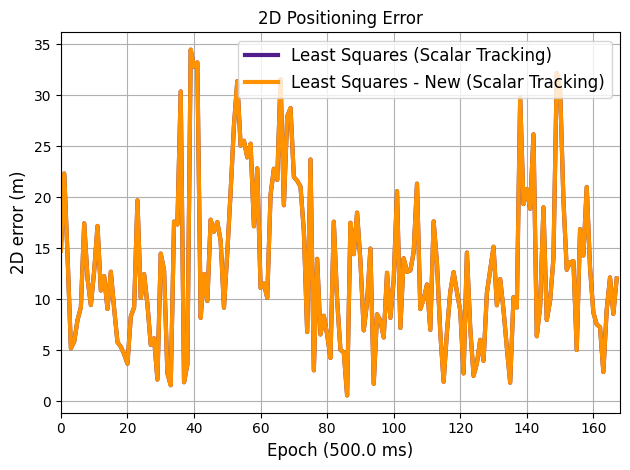

In [41]:
# === Plot 2D positioning error ===========================================
plt.figure()

ab, = plt.plot(ls_2d_list, color='#501D8A', linewidth=3, label='Least Squares (Scalar Tracking)')
bc, = plt.plot(ls_2d_list_new, color='#FF9200', linewidth=3, label='Least Squares - New (Scalar Tracking)')

plt.legend(fontsize=12)
label_xaxis = f"Epoch ({navSolPeriod} ms)"
plt.xlabel(label_xaxis, fontsize=12)
plt.ylabel('2D error (m)', fontsize=12)
plt.xlim([0, len(ls_2d_list)])
len(ls_2d_list)
plt.title(f"2D Positioning Error")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
navSolutions_E = navSolutions[0][0][17][0]
navSolutions_N = navSolutions[0][0][18][0]
navSolutions_U = navSolutions[0][0][19][0]
refCoord_E = np.mean(navSolutions_E[~np.isnan(navSolutions_E)])
refCoord_N = np.mean(navSolutions_N[~np.isnan(navSolutions_N)])
refCoord_U = np.mean(navSolutions_U[~np.isnan(navSolutions_U)])
# Criação da figura
plt.figure(figsize=(10, 5))  # Ajuste de tamanho para melhor visualização
plt.plot(navSolutions_E - refCoord_E, label='E')
plt.plot(navSolutions_N - refCoord_N, label='N')
plt.plot(navSolutions_U - refCoord_U, label='U')
plt.xlim([0, len(navSolutions_E)])
# Configurações do gráfico
plt.title('Coordinates Variations in UTM System')
plt.xlabel(f'Measurement period: {navSolPeriod} ms')
plt.ylabel('Variations (m)')
plt.legend()
plt.grid()
plt.tight_layout()  # Ajuste para evitar sobreposição
plt.show() 